In [1]:
import os
import numpy as np
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
import ParticleTransformer as ParT
from DeepSetNeuralNetArchitecture import PredictOnEpoch
import ConvolutionalRecurrentNeuralNetworkArchitecture as CRNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from sklearn.feature_selection import mutual_info_regression
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-01-16 09:46:47.562655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 09:46:47.742355: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 09:46:47.746841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 09:46:47.746858: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'red'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [3]:
#wandb.init(project = "hffrag-DeepNetNeuralNetworkArchitecture")

wandb: Currently logged in as: kaylendarnbrook. Use `wandb login --relogin` to force relogin


In [4]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [5]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 128 # This is the batch size of the mini batches used during training
EPOCHS = 512 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-3 #This is the default learning rate

In [6]:
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores")
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [7]:
"""
wandb.config = {
    "learning_rate": LR,
    "epochs":EPOCHS,
    "batch_size":BATCHSIZE,
    "max_events": MAXEVENTS,
    "MAXTRACKS": MAXTRACKS, 
}"""

In [8]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]

In [9]:
# Read in the dat from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [10]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [11]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [12]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [13]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 32 inputs


In [14]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [15]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:103: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [16]:
Scaler = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1,Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape= (Num_events,Num_tracks,Num_features))

In [17]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.8, random_state=42)

In [18]:
X_train_event, y_train_event = np.array([X_train[0]]), np.array([y_train[0]])
X_valid_event, y_valid_event = np.array([X_valid[0]]), np.array([y_valid[0]])
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_train_event),np.shape(y_train_event))

(54514, 32, 8) (54514, 3)
(1, 32, 8) (1, 3)


In [19]:
#Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(y_train), np.shape(y_valid))

(54514, 32, 8) (13629, 32, 8)
(54514, 3) (13629, 3)


In [20]:
#Save the training and validation datasets.
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy",X_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy",X_valid)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy",y_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy",y_valid)

In [21]:
#Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-3,
maximal_learning_rate = 0.01,
scale_fn = lambda x: 1/(2**(x-1)),
step_size = 2.0 * steps_per_epoch
)
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs ={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs = {}):
        self.logs.append(timer() - self.starttime)
        
# Builds the deep neural network
track_layers = [64,64,64,64,64]
jet_layers = [128,128.128,128,128,128,128]

len1 = [len(track_features)]+track_layers
print(len1)

#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(clr)
optimizer_Constant = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9, clipnorm = 1.0, nesterov = True )

#Builds the DeepSet Neural Network
DeepNet = DSNNA.DeepSetNeuralNetwork(
    [len(track_features)] + track_layers, jet_layers,np.shape(y_train)[1],optimizer)

[8, 128, 128, 128, 128, 128]


2023-01-16 09:48:44.007372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-16 09:48:44.007403: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-16 09:48:44.007441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-01-16 09:48:44.009340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#Summarises the Deep Set Neural Network Architecture
print(DeepNet.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 128)        1152  

In [23]:
#plot_model(DeepNet, to_file ="NetworkArchitecture.png", show_shapes = True, show_layer_names = True)

In [24]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=15,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.80, patience=10, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [25]:
# Train the neural network
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid,y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,PredictOnEpoch(DeepNet,X_train,y_train),cb,cp_callback],
)

Epoch 1/512


2023-01-16 09:48:51.600416: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f75fc0c3cc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-16 09:48:51.600459: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-01-16 09:48:51.893014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-16 09:48:51.927492: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. model/dropout/dropout/random_uniform/RandomUniform


  3/426 [..............................] - ETA: 11s - loss: 473997246464.0000    

2023-01-16 09:48:58.652611: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


426/426 [==============================] - 39s 59ms/step - loss: 73772539904.0000 - val_loss: 8649522176.0000 - lr: 0.0010
Epoch 2/512
426/426 [==============================] - 16s 37ms/step - loss: 11918652416.0000 - val_loss: 5813428224.0000 - lr: 0.0011
Epoch 3/512
426/426 [==============================] - 16s 38ms/step - loss: 5767526912.0000 - val_loss: 4409147904.0000 - lr: 0.0011
Epoch 4/512
426/426 [==============================] - 16s 37ms/step - loss: 3372967168.0000 - val_loss: 2545849088.0000 - lr: 0.0011
Epoch 5/512
426/426 [==============================] - 16s 37ms/step - loss: 2010244608.0000 - val_loss: 1461663104.0000 - lr: 0.0012
Epoch 6/512
426/426 [==============================] - 16s 37ms/step - loss: 1300629120.0000 - val_loss: 796964352.0000 - lr: 0.0012
Epoch 7/512
426/426 [==============================] - 16s 37ms/step - loss: 824643904.0000 - val_loss: 757911168.0000 - lr: 0.0012
Epoch 8/512
426/426 [==============================] - 16s 37ms/step - loss

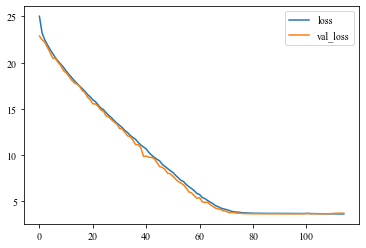

In [26]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [27]:
print(sum(cb.logs))

1903.9535494562588


In [28]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 38.224449157714844


In [29]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

2130/2130 - 6s - loss: 38.6860 - 6s/epoch - 3ms/step
The Loaded DeepNet has loss:  38.68604278564453


In [ ]:
PredictionsNeural = DeepNet.predict(tracks)
print(PredictionsNeural.shape)

In [30]:
get_sum_layer_output = k.function([DeepNet.layers[0].input],
                                 [DeepNet.layers[13].output])
layer_output = get_sum_layer_output(tracks)[0]
print(layer_output.shape)

(68143, 128)


In [31]:
mi_scores_px_momentum =  make_mi_scores(layer_output, bhads[:,1])
print(mi_scores_px_momentum)

23     0.340518
81     0.262908
83     0.217832
24     0.211830
86     0.176563
         ...   
122    0.010743
93     0.010052
54     0.008995
108    0.008464
124    0.007563
Name: MI Scores, Length: 128, dtype: float64

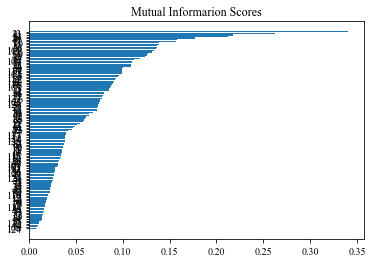

In [32]:
plt.Figure(dpi = 200,figsize = (100,100))
plot_mi_scores(mi_scores_px_momentum)

In [33]:
X_train_ml,X_valid_ml,y_train_ml,y_valid_ml = train_test_split(layer_output,bhads[:,0],random_state = 42)

In [34]:
from xgboost import XGBRegressor
xgbooster = XGBRegressor(n_estimators = 6000, num_parallel_tree = 1,early_stopping_rounds= 5, learning_rate = 1e-3)
xgbooster.fit(X_train_ml,y_train_ml, eval_set = [(X_valid_ml,y_valid_ml)], verbose = False)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = xgbooster.predict(X_valid_ml)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid_ml)))

Mean Absolute Error: 23605.649141930742


In [ ]:
Predictions = xgbooster.predict(X_train_ml)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_xgbooster = (Predictions - y_train_ml)/std
mean2 = np.mean(Pull_xgbooster)
std2 = np.std(Pull_xgbooster)
print(mean,std)
print(mean2,std2)

154.77422 52328.258
8.135133982294325e-05 0.5825714633571546


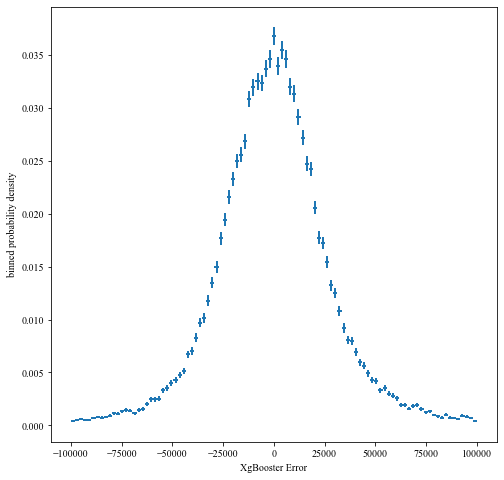

In [ ]:
fig = binneddensity(Predictions - y_train_ml, fixedbinning(-100000,100000,100), xlabel ="XgBooster Error")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/XgboostError")

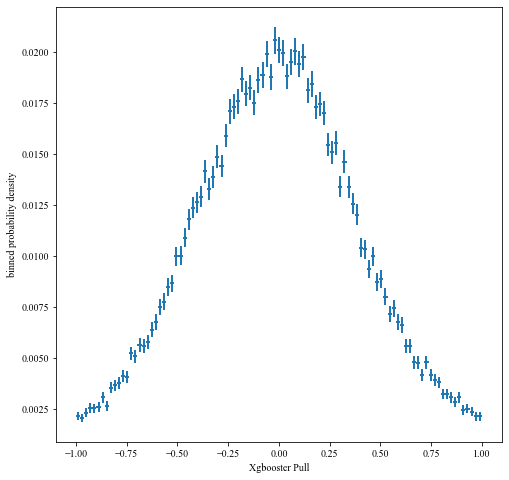

In [ ]:
fig2 = binneddensity(Pull_xgbooster, fixedbinning(-1,1,100), xlabel ="Xgbooster Pull")
fig2.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/XgboostError")

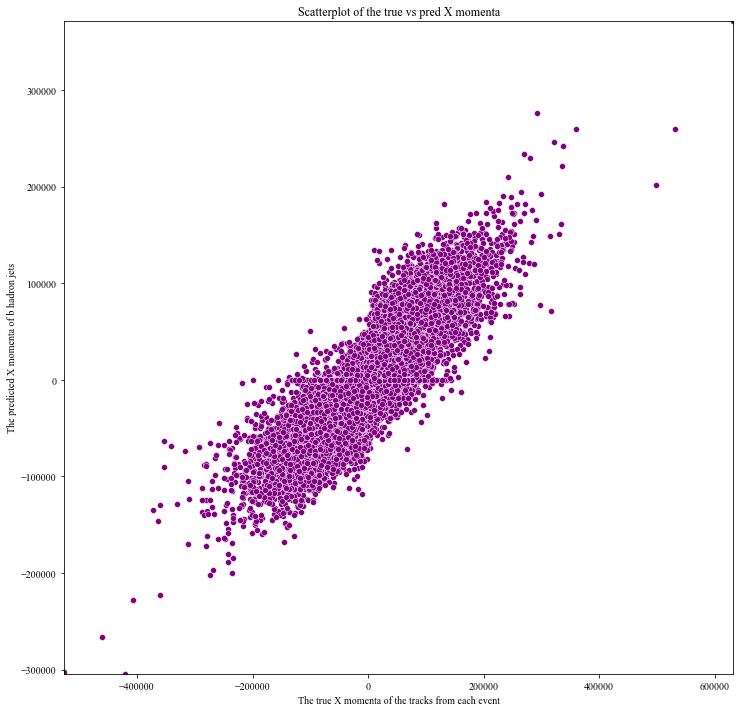

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_train_ml,
    y = Predictions,
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(y_train_ml),np.max(y_train_ml)])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = PredictionsNeural[:,0],
    x = bhads,
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(PredictionsNeural),np.max(PredictionsNeural)])
ax.set_ylim([np.min(bhads),np.max(bhads)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")